In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from glob import glob
import pickle
from pprint import pprint
import random
import traceback
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image

import cv2
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams["figure.figsize"] = (12, 9)
sns.set_style("darkgrid")

In [4]:
IMG_WIDTH = 600
IMG_HEIGHT = 250

## Loading the train and test data

In [5]:
train = sorted(list(glob("../input/arya-hw-lines/train/train/*.tif")))
test = sorted(list(glob("../input/arya-hw-lines/test/test/*.tif")))

In [6]:
len(train), len(test)

(11000, 994)

In [7]:
idx = 100
image = cv2.imread(train[idx], 0)
label = open(train[idx].replace(".tif", ".gt.txt")).read()

TO CEASE HIS NEGOTIATIONS WITH


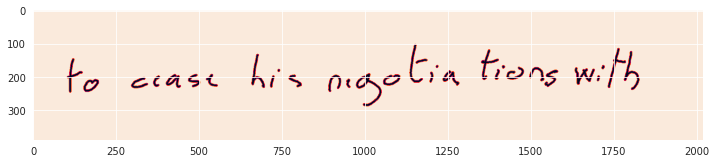

In [8]:
print(label)
_ = plt.imshow(image)

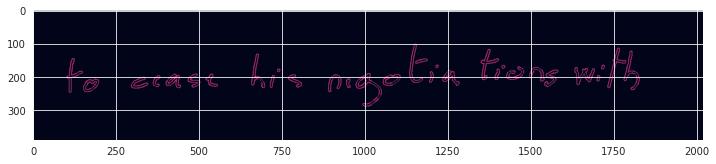

In [9]:
image_invert = np.abs(image-255)
_ = plt.imshow(image_invert)

In [10]:
vert_sum = np.sum(image_invert, axis=0)
hori_sum = np.sum(image_invert, axis=1)
len(vert_sum), len(hori_sum)

(2019, 390)

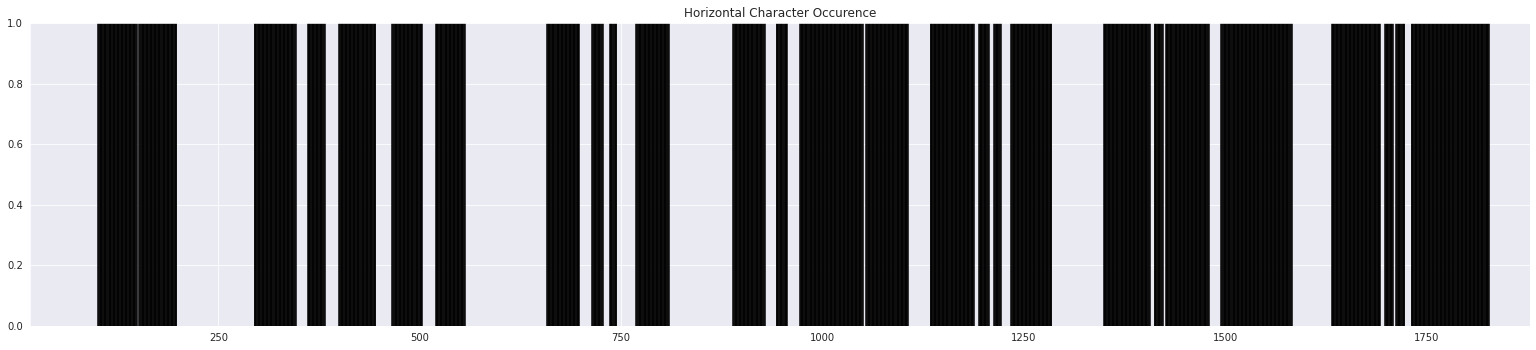

In [11]:
px = 1/plt.rcParams['figure.dpi']
plt.subplots(figsize=(1935*px, 401*px))
xposition = list(range(0, image_invert.shape[1]))
for xc in xposition:
    if vert_sum[xc] > 0:
        plt.axvline(x=xc, color='k')
_ = plt.title("Horizontal Character Occurence")

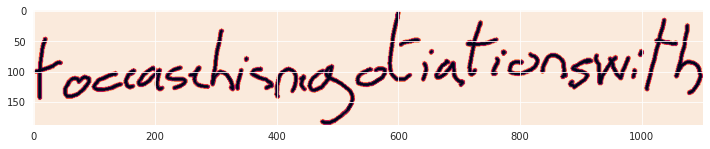

In [12]:
# consider only those horizontal & vertical sections where atleast one pixel value>0
image_reduced  = image[hori_sum>0,:][:,vert_sum>0]
_ = plt.imshow(image_reduced)

In [13]:
# stores the index at which 0 starts as keys & the consecutive number of 0 pixels as value
gaps = {}
sanchk = True
tmp_ind = 0
for ind, i in enumerate(vert_sum):
    if i==0:
        if sanchk:
            tmp_ind = ind
            gaps[tmp_ind] = 0
        gaps[tmp_ind]+=1
        sanchk = False
    else:
        sanchk = True

In [14]:
pprint(gaps)
len(vert_sum[vert_sum==0]), sum(gaps.values())

{0: 101,
 150: 2,
 199: 96,
 347: 14,
 383: 17,
 446: 20,
 504: 16,
 557: 101,
 699: 15,
 728: 8,
 745: 24,
 810: 79,
 929: 14,
 957: 15,
 1051: 3,
 1107: 27,
 1189: 5,
 1207: 6,
 1222: 12,
 1285: 64,
 1407: 5,
 1423: 3,
 1480: 15,
 1583: 49,
 1693: 5,
 1709: 3,
 1723: 8,
 1828: 191}


(918, 918)

In [15]:
# cutting off whitespaces at the start & end (along x-axis)
start_ind = 0
end_ind = vert_sum.shape[0]-1
if 0 in gaps:
    start_ind = gaps[0]
    del gaps[0]
gaps_last = max(gaps.keys())
if gaps_last+gaps[gaps_last]-1 == end_ind:
    end_ind = gaps_last
    del gaps[gaps_last]
image = image[hori_sum>0,:][:,start_ind:end_ind]

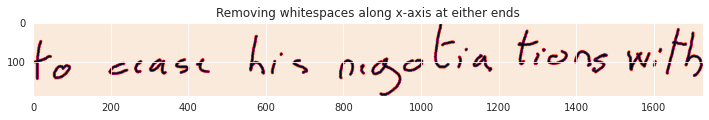

In [16]:
plt.imshow(image)
_ = plt.title("Removing whitespaces along x-axis at either ends")

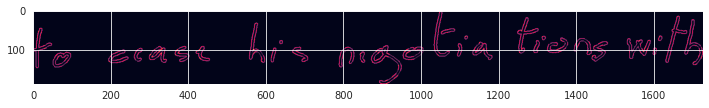

In [17]:
image_invert = np.abs(image-255)
_ = plt.imshow(image_invert)

In [18]:
# re-calculating gap after removing whitespaces
vert_sum = np.sum(image_invert,axis=0)
gaps = {}
sanchk = True
tmp_ind = 0
for ind, i in enumerate(vert_sum):
    if i==0:
        if sanchk:
            tmp_ind = ind
            gaps[tmp_ind] = 0
        gaps[tmp_ind]+=1
        sanchk = False
    else:
        sanchk = True

In [19]:
gaps

{49: 2,
 98: 96,
 246: 14,
 282: 17,
 345: 20,
 403: 16,
 456: 101,
 598: 15,
 627: 8,
 644: 24,
 709: 79,
 828: 14,
 856: 15,
 950: 3,
 1006: 27,
 1088: 5,
 1106: 6,
 1121: 12,
 1184: 64,
 1306: 5,
 1322: 3,
 1379: 15,
 1482: 49,
 1592: 5,
 1608: 3,
 1622: 8}

*Based on the hypothesis that distance between 2 words is more than intra-word space as well as space between two characters*

In [20]:
text_pieces = label.split(" ")
label_length = len(text_pieces)
# minimum gap between two words
min_gap = sorted(gaps.values())[-label_length]

In [21]:
print(sorted(gaps.values()))
print(f"Minimum gap between 2 words: {min_gap}")

[2, 3, 3, 3, 5, 5, 5, 6, 8, 8, 12, 14, 14, 15, 15, 15, 16, 17, 20, 24, 27, 49, 64, 79, 96, 101]
Minimum gap between 2 words: 49


In [22]:
# split image only if gap > minimum gap & store the starting pixel index for the word
splits = np.arange(vert_sum.shape[0])[[k for k in gaps.keys() if gaps[k]>min_gap]]
print(f"Starting index for each word (x-axis): {splits}")

Starting index for each word (x-axis): [  98  456  709 1184]


In [23]:
if splits.shape[0]>0:
    image_splits = np.split(image,indices_or_sections=splits,axis=1)
else:
    image_splits = [image]
    splits = [0]

**Setting maximum `image_width` to 600 pixels, since the plan is to anyway train the model on words lesser than 8 characters**

In [24]:
image_pieces = []
for ind, tmp in enumerate(image_splits):
    start_index = gaps[splits[ind-1]] if ind>0 else 0
    if tmp[:, start_index:].shape[1]==0:
        continue
    image_pieces.append(np.pad(tmp[:,start_index:], 
                               ((0, IMG_HEIGHT-tmp[:,start_index:].shape[0]), (0, IMG_WIDTH-tmp[:,start_index:].shape[1])),
                               'constant', 
                               constant_values=255))

In [25]:
text_pieces

['TO', 'CEASE', 'HIS', 'NEGOTIATIONS', 'WITH']

In [26]:
all_labels = []

In [27]:
count = 0
if len(text_pieces) == len(image_pieces):
    for image in image_pieces:
        Image.fromarray(image).save(f"{count}.png")
        count+=1
    all_labels.extend(text_pieces)

In [28]:
temp_df = pd.DataFrame.from_dict({"Path": list(range(count)), "Labels": all_labels})
temp_df["Path"] = temp_df["Path"].apply(lambda x: str(x)+".png")

In [29]:
def plot_grid(files, labels=None, h=3, w=3, title=""):
    if not labels:
        labels = [""]*len(files)
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    for idx, (path, label) in enumerate(random.choices(list(zip(files, labels)), k=h*w)):
        image = cv2.imread(path, 0)
        
        ax[idx // h, idx % w].imshow(image)
        ax[idx // h, idx % w].axis("off")
        ax[idx // h, idx % w].set_title(f"{path.split('/')[-1]} - {label}")
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

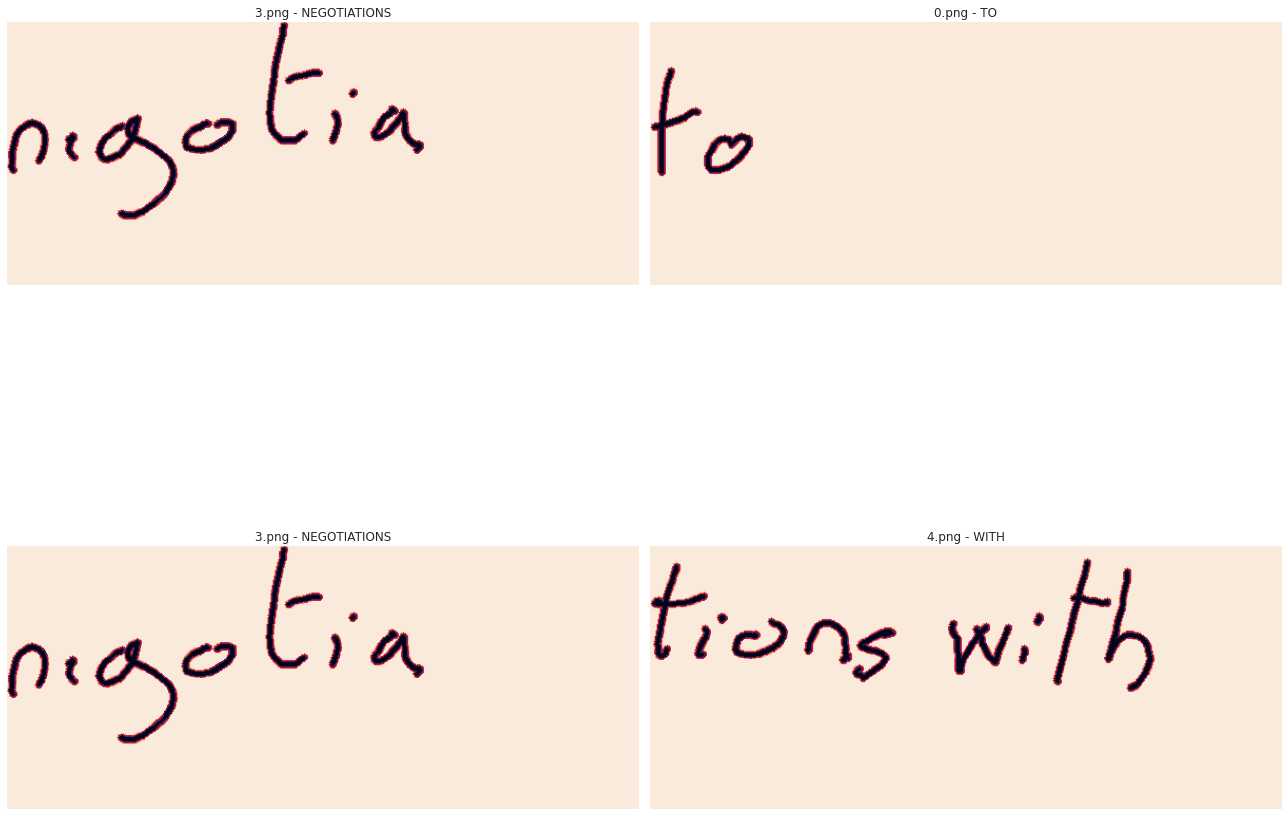

In [30]:
plot_grid(temp_df["Path"].tolist(), temp_df["Labels"].tolist(), h=2, w=2)

## Remove Error Cases

Refer [here](https://www.kaggle.com/aditya08/initial-exploration?scriptVersionId=58103586&cellId=33)

In [31]:
issue = ["g04-036-07.tif", "d09-651z-05.tif", "f06-396z-09.tif", 
         "f04-310z-05.tif", "f07-425z-08.tif", "b06-032-09.tif", 
         "l06-637z-06.tif", "d03-229z-06.tif", "n10-277z-06.tif", 
         "n01-015z-04.tif", "n01-062z-07.tif", "d05-380z-06.tif"]
issue = [f"../input/arya-hw-lines/train/train/{x}" for x in issue]

In [32]:
train = sorted(list(set(train) - set(issue)))

In [33]:
len(train)

10988

## All in One

In [34]:
!mkdir images

In [35]:
count, error_count, all_labels = 0, 0, []
image_paths, subimage_splits, image_counts = [], [], []
h_shape, w_shape, aspect_ratio = [], [], []
for fnum in tqdm(range(len(train))):
    prev_count = count
    try:
        image = cv2.imread(train[fnum], 0)
        label = open(train[fnum].replace(".tif", ".gt.txt")).read()
        image_invert = np.abs(image-255)
        vert_sum = np.sum(image_invert,axis=0)
        hori_sum = np.sum(image_invert,axis=1)
        image_reduced  = image[hori_sum>0,:][:,vert_sum>0]
        
        gaps = {}
        sanchk = True
        tmp_ind = 0
        for ind, i in enumerate(vert_sum):
            if i==0:
                if sanchk:
                    tmp_ind = ind
                    gaps[tmp_ind] = 0
                gaps[tmp_ind]+=1
                sanchk = False
            else:
                sanchk = True
        start_ind = 0
        end_ind = vert_sum.shape[0]-1
        if 0 in gaps:
            start_ind = gaps[0]
            del gaps[0]
        gaps_last = max(gaps.keys())
        if gaps_last+gaps[gaps_last]-1 == end_ind:
            end_ind = gaps_last
            del gaps[gaps_last]
        image = image[hori_sum>0,:][:,start_ind:end_ind]

        image_invert = np.abs(image-255)
        vert_sum = np.sum(image_invert,axis=0)
        gaps = {}
        sanchk = True
        tmp_ind = 0
        for ind, i in enumerate(vert_sum):
            if i==0:
                if sanchk:
                    tmp_ind = ind
                    gaps[tmp_ind] = 0
                gaps[tmp_ind]+=1
                sanchk = False
            else:
                sanchk = True
        
        text_pieces = label.split(" ")        
        label_length = len(text_pieces)
        min_gap = sorted(gaps.values())[-label_length]
        splits = np.arange(vert_sum.shape[0])[[k for k in gaps.keys() if gaps[k]>min_gap]]
        if splits.shape[0]>0:
            image_splits = np.split(image, indices_or_sections=splits, axis=1)
        else:
            image_splits = [image]
            splits = [0]
        
        # store original dimensions for each word
        for img in image_splits:
            h_shape.append(img.shape[0])
            w_shape.append(img.shape[1])
            aspect_ratio.append(1.0 * (img.shape[1] / img.shape[0]))
        
        # adds padding
        image_pieces = []
        for ind, tmp in enumerate(image_splits):
            start_index = gaps[splits[ind-1]] if ind>0 else 0
            if tmp[:,start_index:].shape[1]==0:
                continue
            image_pieces.append(np.pad(tmp[:,start_index:], 
                                       ((0, IMG_HEIGHT-tmp[:,start_index:].shape[0]), (0, IMG_WIDTH-tmp[:,start_index:].shape[1])),
                                       'constant', 
                                       constant_values=255))

        # saving images & corresponding words
        if len(text_pieces) == len(image_pieces):
            for image in image_pieces:
                Image.fromarray(image).save(f"images/{count}.png")
                count+=1
            all_labels.extend(text_pieces)
        subimage_splits.append(list(range(prev_count, count)))
        image_paths.append(train[fnum])
        image_counts.append(count-prev_count)
    except Exception as e:
        error_count += 1
#         print(e, fnum)
#         traceback.print_exc()
#         break
print(f"# Errenous Cases: {error_count}")
print(f"# Total Words: {count}")

100%|██████████| 10988/10988 [08:30<00:00, 21.52it/s]

# Errenous Cases: 2139
# Total Words: 48018


*Will have to live with these many error cases* ;)

In [36]:
len(image_paths), len(subimage_splits), len(image_counts)

(8849, 8849, 8849)

In [37]:
train_df = pd.DataFrame.from_dict({"Path": image_paths, "Splits": subimage_splits, "NumSplits": image_counts})

In [38]:
train_df.head()

,Path,Splits,NumSplits
0,../input/arya-hw-lines/train/train/a01-000u-01...,"[0, 1, 2, 3, 4, 5, 6]",7
1,../input/arya-hw-lines/train/train/a01-000u-02...,"[7, 8, 9, 10, 11]",5
2,../input/arya-hw-lines/train/train/a01-000u-03...,"[12, 13, 14, 15, 16, 17, 18, 19]",8
3,../input/arya-hw-lines/train/train/a01-000u-04...,"[20, 21, 22, 23, 24, 25]",6
4,../input/arya-hw-lines/train/train/a01-000u-05...,"[26, 27, 28, 29, 30, 31, 32, 33]",8


In [39]:
df = pd.DataFrame.from_dict({"Path": list(range(count)), "Labels": all_labels})
df["Path"] = df["Path"].apply(lambda x: f"images/{x}.png")

In [40]:
df.head()

,Path,Labels
0,images/0.png,A
1,images/1.png,MOVE
2,images/2.png,TO
3,images/3.png,STOP
4,images/4.png,MR


In [41]:
train_df.shape, df.shape

((8849, 3), (48018, 2))

In [42]:
# sanity-check
print(f"# Splits matching in both dataframes: {df.shape[0]==train_df['NumSplits'].sum()}")

# Splits matching in both dataframes: True


**Plotting word level dimensions**

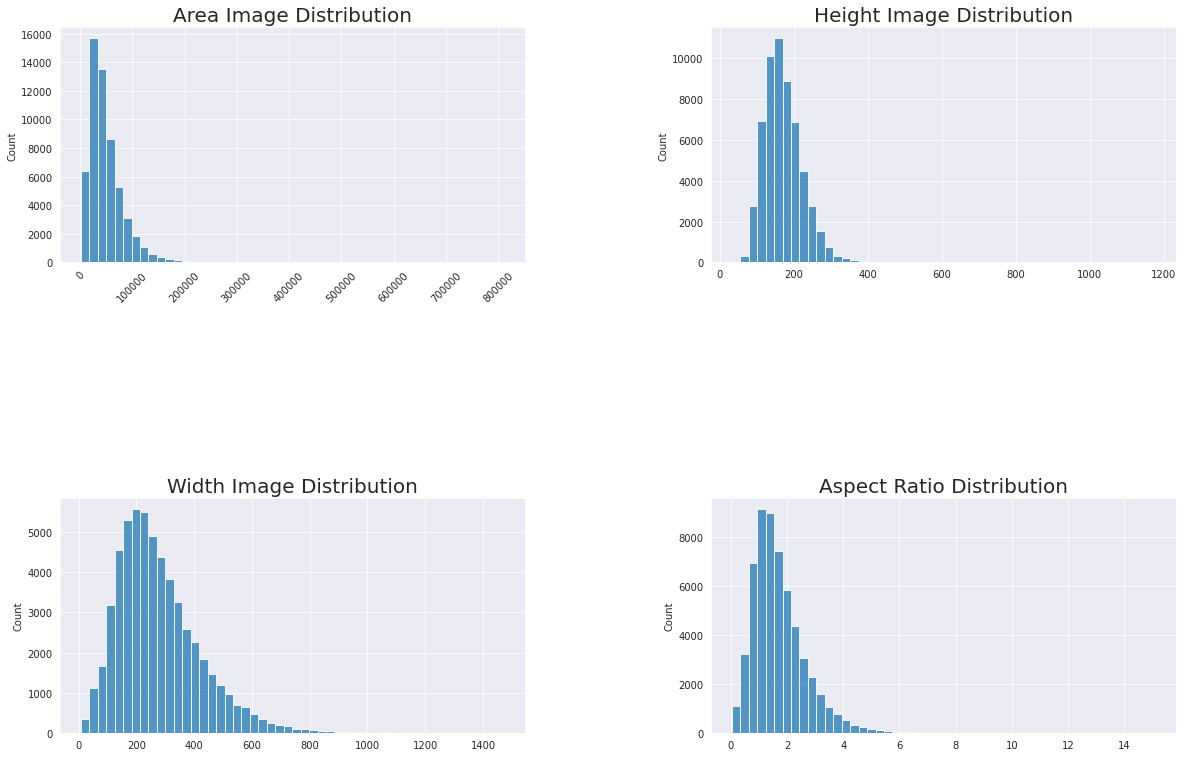

In [43]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(top = 0.5, bottom=0.01, hspace=1, wspace=0.4)

plt.subplot(2, 2, 1)
sns.histplot(np.array(h_shape) * np.array(w_shape), bins=50)
plt.xticks(rotation=45)
_ = plt.title("Area Image Distribution", fontsize=20)

plt.subplot(2, 2, 2)
sns.histplot(h_shape, bins=50)
_ = plt.title("Height Image Distribution", fontsize=20)

plt.subplot(2, 2, 3)
sns.histplot(w_shape, bins=50)
_ = plt.title("Width Image Distribution", fontsize=20)

plt.subplot(2, 2, 4)
sns.histplot(aspect_ratio, bins=50)
_ = plt.title("Aspect Ratio Distribution", fontsize=20)

## Removing Further Error Cases

### Mismatch - Type 1
***For cases where `len(gaps) > len(label)` are problematic cases***

Should it be modified to `len(gaps) > len(label)-1` as there's bound to be `n-1` gaps at max in a word of length `n`?

In [44]:
error_count, error_path, error_words = 0, [], []

for path, label in tqdm(zip(df["Path"].tolist(), df["Labels"].tolist())):
    try:
        image = cv2.imread(path, 0)
        image_invert = np.abs(image-255)
        vert_sum = np.sum(image_invert,axis=0)
        hori_sum = np.sum(image_invert,axis=1)
        image_reduced  = image[hori_sum>0,:][:,vert_sum>0]

        gaps = {}
        sanchk = True
        tmp_ind = 0
        for ind, i in enumerate(vert_sum):
            if i==0:
                if sanchk:
                    tmp_ind = ind
                    gaps[tmp_ind] = 0
                gaps[tmp_ind]+=1
                sanchk = False
            else:
                sanchk = True

        # cutting off whitespaces at the start & end (along x-axis)
        start_ind = 0
        end_ind = vert_sum.shape[0]-1
        if 0 in gaps:
            start_ind = gaps[0]
            del gaps[0]
        gaps_last = max(gaps.keys())
        if gaps_last+gaps[gaps_last]-1 == end_ind:
            end_ind = gaps_last
            del gaps[gaps_last]
        image = image[hori_sum>0,:][:,start_ind:end_ind]

        image_invert = np.abs(image-255)
        # re-calculating gap after removing whitespaces
        vert_sum = np.sum(image_invert,axis=0)
        gaps = {}
        sanchk = True
        tmp_ind = 0
        for ind, i in enumerate(vert_sum):
            if i==0:
                if sanchk:
                    tmp_ind = ind
                    gaps[tmp_ind] = 0
                gaps[tmp_ind]+=1
                sanchk = False
            else:
                sanchk = True
        
        if len(gaps) > len(label):
            error_count+=1
            error_path.append(path)
            error_words.append(label)
    except Exception as e:
        print(label)
        plt.figure()
        plt.imshow(image)

48018it [03:24, 234.27it/s]


In [45]:
print(f"# Errors: {error_count}")
len(error_path), len(error_words)

# Errors: 587


(587, 587)

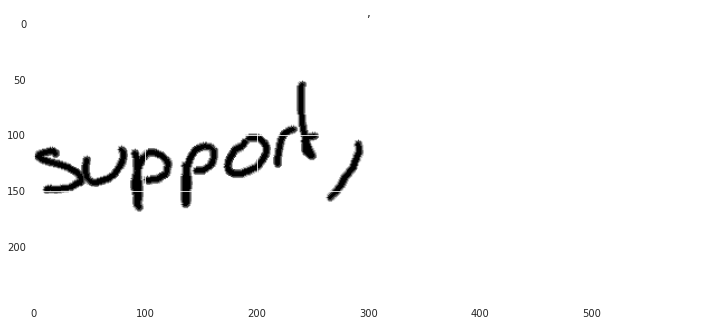

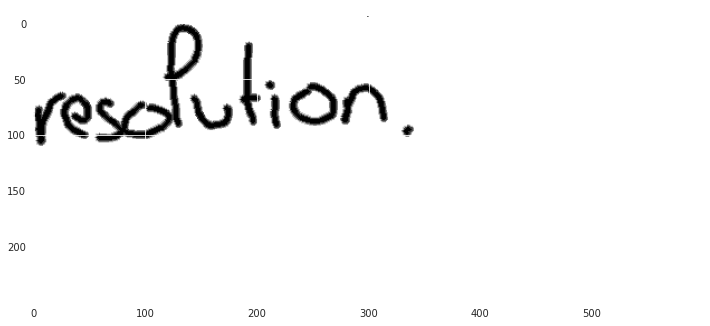

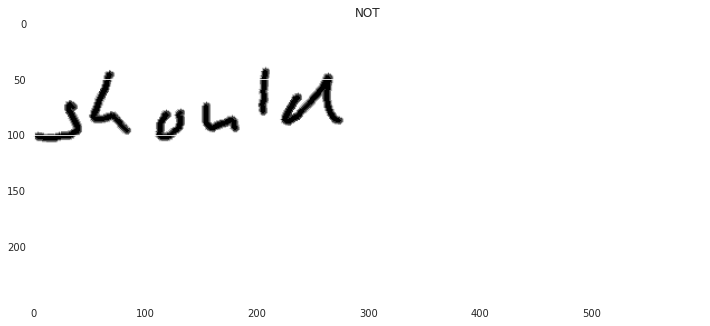

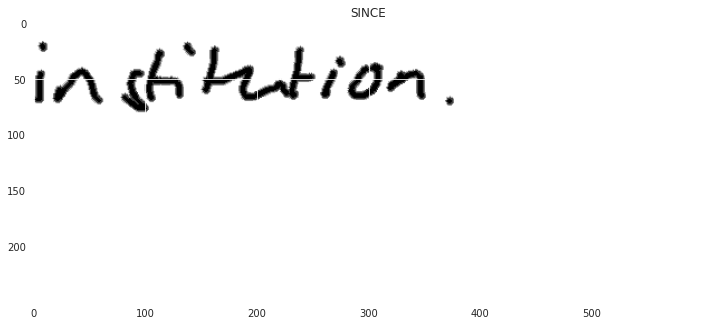

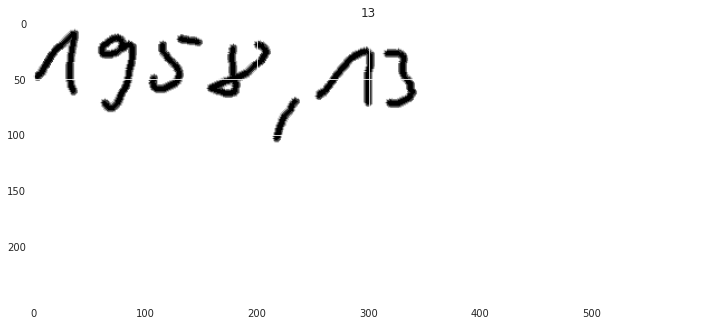

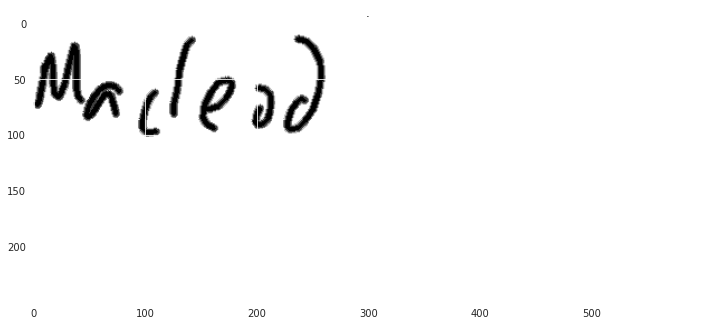

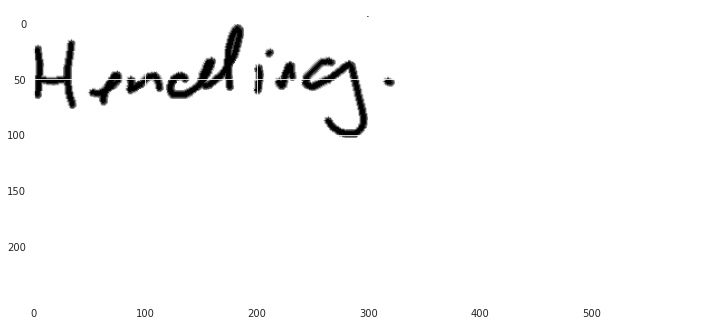

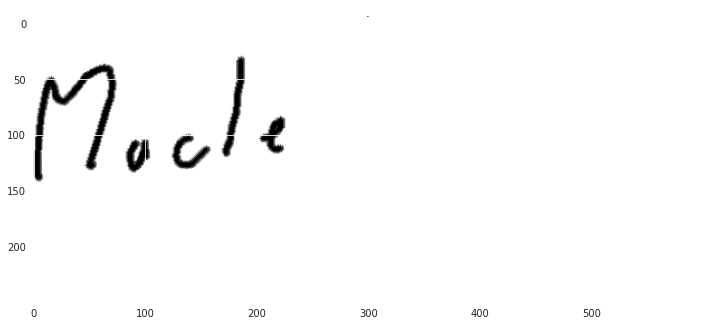

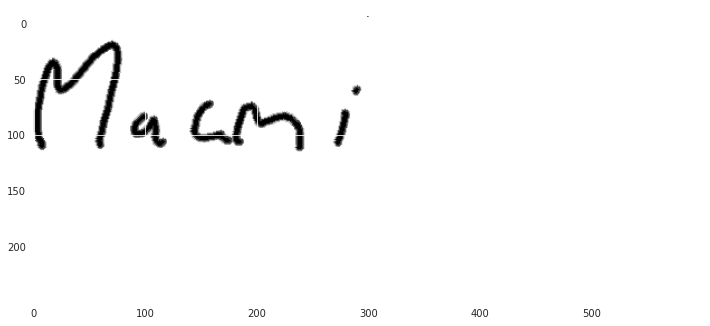

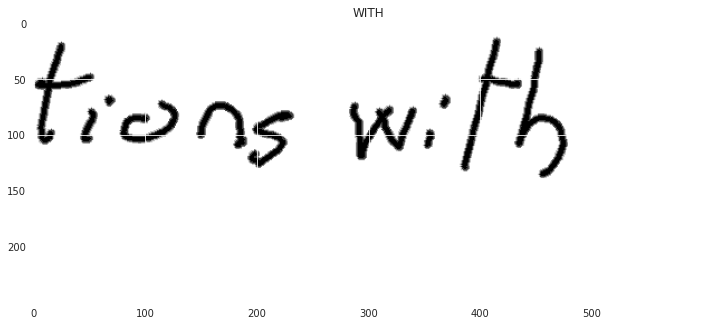

In [46]:
for path, label in zip(error_path[:10], error_words[:10]):
    img = cv2.imread(path)
    plt.figure()
    plt.imshow(img)
    plt.title(label)

***It's possible that the original image of which the above are sub-images too would be incorrect. Let's check***

In [47]:
x = int(error_path[2].split("/")[1].split(".")[0])
y = train_df.loc[train_df["Splits"].apply(lambda y: x in y)]["Splits"].tolist()[0]
print(x, y)

145 [143, 144, 145, 146, 147, 148]


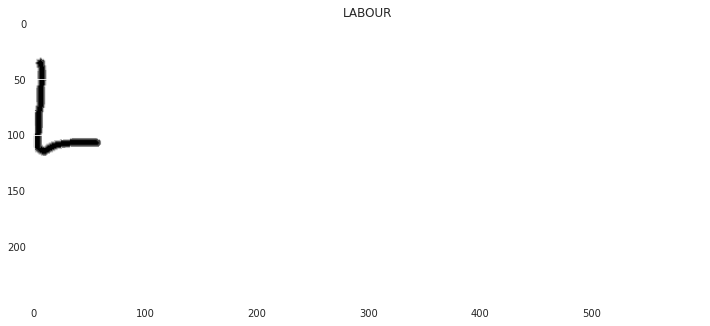

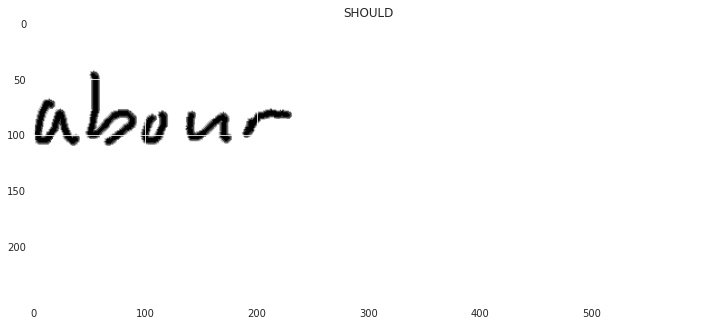

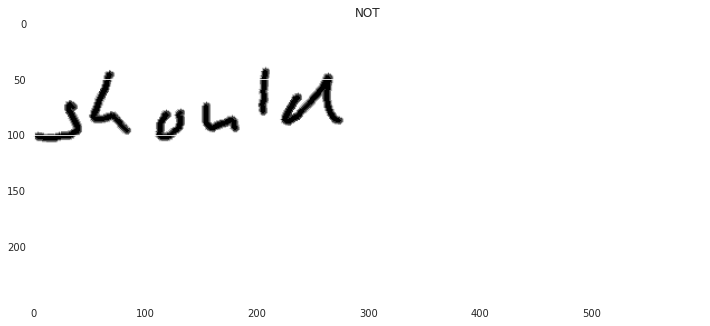

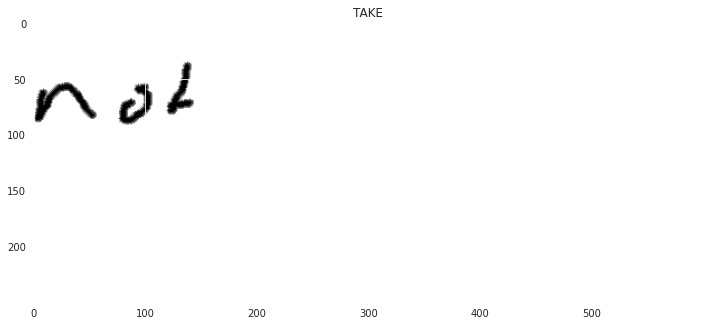

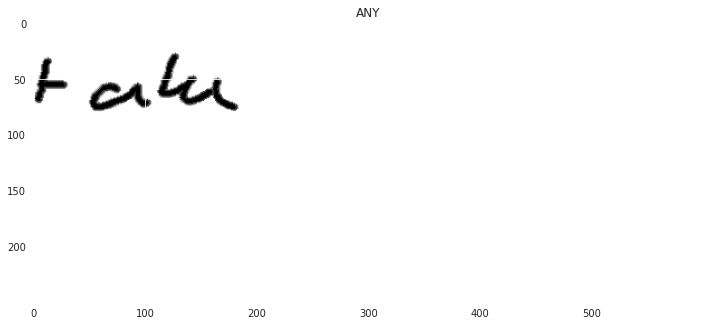

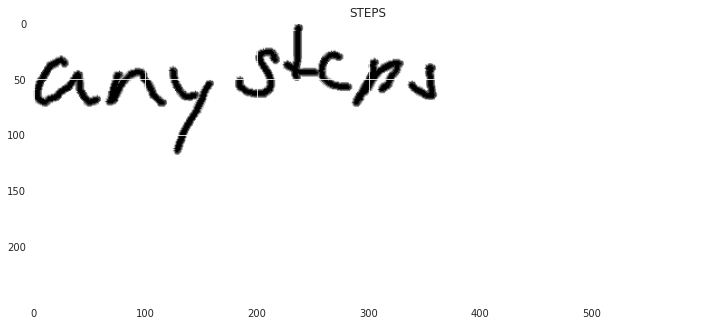

In [48]:
for idx, row in df.iloc[y].iterrows():
    img = cv2.imread(row["Path"])
    label = row["Labels"]
    plt.figure()
    plt.imshow(img)
    plt.title(label)

> Removing error cases & those of which they were a part

In [49]:
df_error_indexes, train_df_error_indexes = [], []
for i in tqdm(range(len(error_path))):
    x = int(error_path[i].split("/")[1].split(".")[0])
    # storing index for both dataframes
    temp = train_df.loc[train_df["Splits"].apply(lambda y: x in y)]
    train_df_error_indexes.append(temp.index.tolist()[0])
    df_error_indexes.extend(temp["Splits"].tolist()[0])
print(f"# Total Error Cases: {len(df_error_indexes)}")

100%|██████████| 587/587 [00:02<00:00, 243.56it/s]

# Total Error Cases: 3810


In [50]:
print(f"# Word Level Errors: {len(df_error_indexes)}")
print(f"# Word Level Errors (Unique): {len(set(df_error_indexes))}")
print(f"# Sentence Level Errors: {len(train_df_error_indexes)}")
print(f"# Sentence Level Errors (Unique): {len(set(train_df_error_indexes))}")
print(f"Sanity Check: {train_df.loc[train_df_error_indexes]['NumSplits'].sum()==len(df_error_indexes)}")

# Word Level Errors: 3810
# Word Level Errors (Unique): 3220
# Sentence Level Errors: 587
# Sentence Level Errors (Unique): 502
Sanity Check: True


In [51]:
df.shape, train_df.shape

((48018, 2), (8849, 3))

In [52]:
# storing from both dataframes
df = df.drop(index=df_error_indexes)
train_df = train_df.drop(index=train_df_error_indexes)

In [53]:
df.shape, train_df.shape

((44798, 2), (8347, 3))

In [54]:
print(f"Sanity Check Again: {train_df['NumSplits'].sum()==df.shape[0]}")

Sanity Check Again: True


### Mismatch - Type 2
***Cases where `len(splits) <  len(word)-1`. However, these are harder to detect, because of `cursive handwriting` which has joint characters***

But let's do it anyways & see if something comes up. **In the worst case, we might remove few from the training data manually**

The procedure is the same as above. Had created a separate notebook for it. Was able to find about 10 images but that was very boring - didn't had much success.

### Manually Removing Cases - Type 3

In [55]:
view_count=0

**Rerun the below cell again & again**


Count: 1




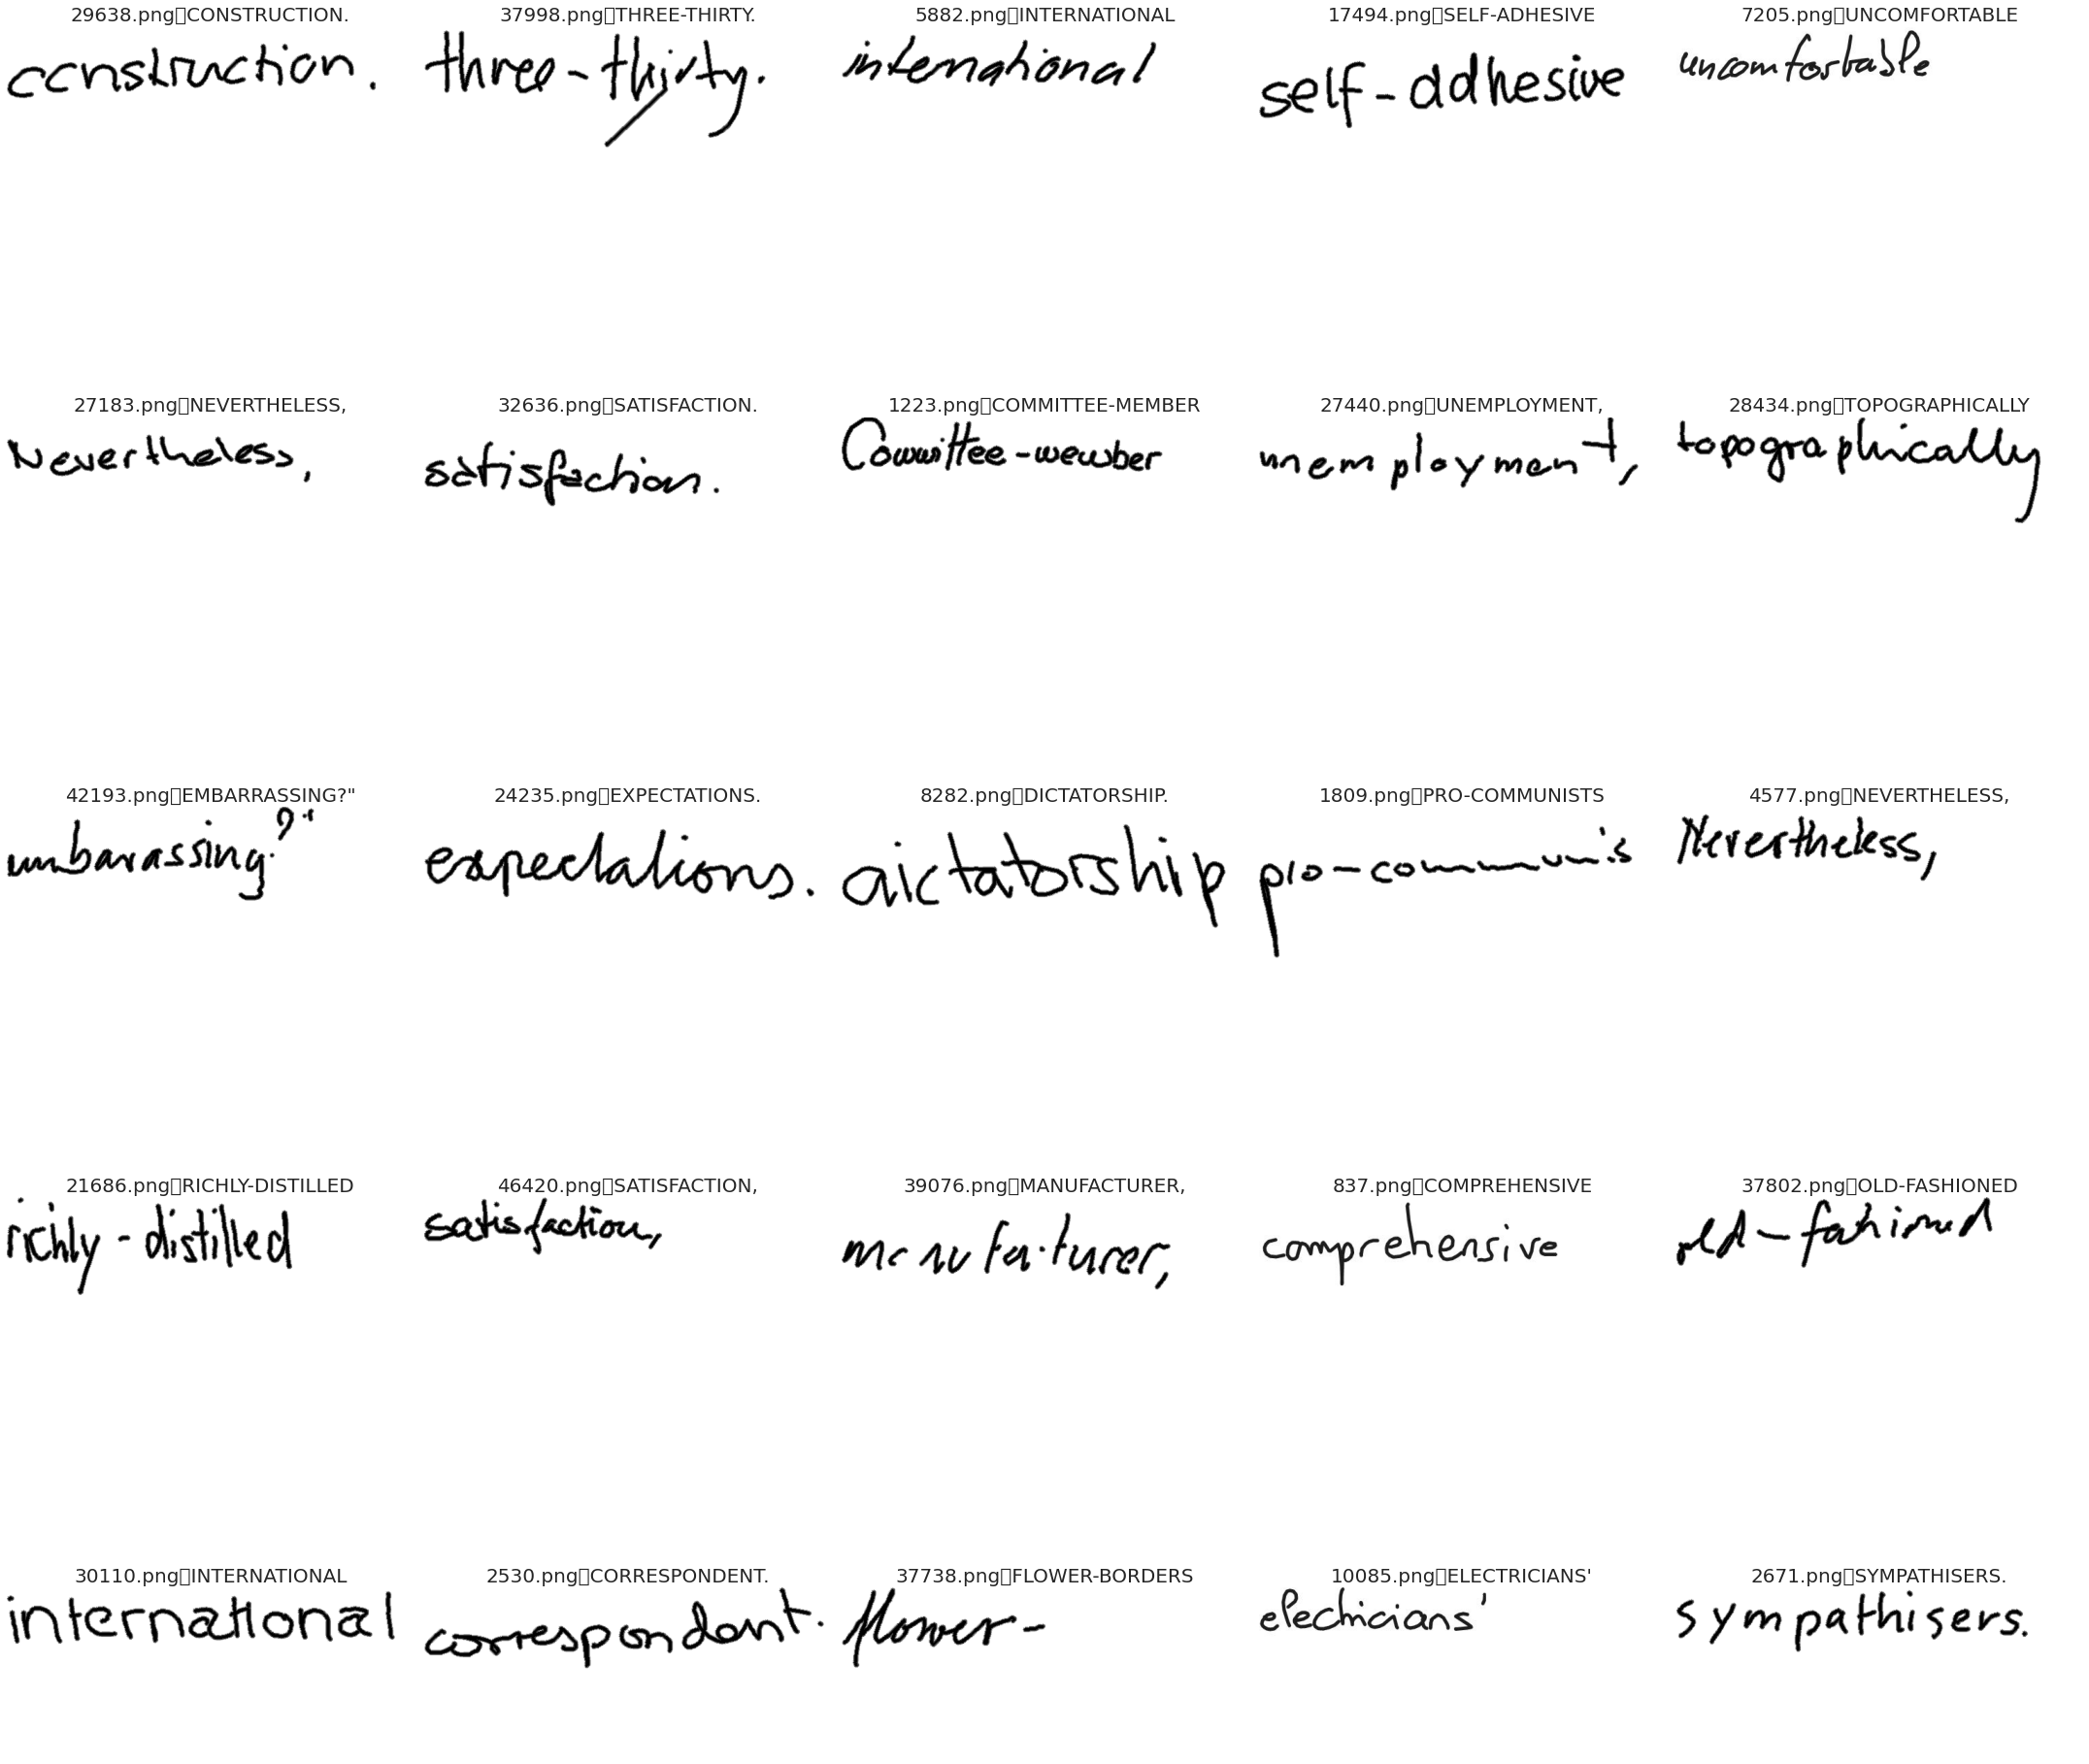

In [56]:
view_count +=1
print(f"\nCount: {view_count}\n\n")
h, w = 5, 5
f, ax = plt.subplots(h, w, figsize=(30, 30))
sub_df = df.loc[df["Labels"].str.len()>12].sample(n=h*w)
images = sub_df["Path"].tolist()
labels = sub_df["Labels"].tolist()
for i in range(h*w):
    img = cv2.imread(images[i])
    ax[i // h, i % w].imshow(img, cmap="gray")
    ax[i // h, i % w].axis("off")
    ax[i // h, i % w].set_title(f"{images[i].split('/')[-1]}\t{labels[i]}", fontdict={"fontsize": 20})
plt.tight_layout()
plt.show()

In [57]:
drop_images = [3829, 8424, 28985, 2924, 9946, 27370, 5596, 30693, 25652, 15666, 
               4150, 26730, 36367, 37749, 18146, 20523, 22783, 44968, 12661, 12890, 45765,
               33083, 26111, 10806, 41712, 9185, 9832, 20582, 47435, 12263, 45790, 35431, 
               36553, 46519, 32951, 35597, 41431, 20889, 33089, 25053, 27888, 43951, 28347, 
               42430, 38264, 42121, 44547, 30372, 5130, 33891, 13586, 8022, 9868, 3036, 44547, 
               44884, 44462, 7624, 27759, 36628, 42148, 6164, 35186, 33478, 25817, 11059, 35101, 
               18652, 13566, 11059, 7691, 5135, 28347, 5668, 27939, 33891, 181, 3103, 47274, 
               14433, 32540, 36623, 22655, 1121, 2087, 9514, 46677, 19782, 32936, 22538, 40633, 
               37733, 31419, 22538, 12281, 26107, 14402, 7686, 13237, 32621, 3025, 10271, 9510, 
               15904, 9493, 6658, 16771, 9041, 25599, 2942, 20702, 2143, 1065, 7408, 898, 895, 
               16809, 13940, 55, 30513, 2143, 20746, 1919, 23228, 1189, 5989, 5, 9827, 16923, 
               45479, 28779,  36977, 37312, 3751, 9038, 35343, 8425, 38337, 18210, 47699, 31711, 
               46883, 33111, 2920, 39722, 27937, 28497, 25955, 34345, 42736, 2199, 37744, 22280, 
               17135, 27776, 40360, 2652, 36979, 36444, 17561, 42924, 2533, 12259, 27546, 34715, 
               25202, 33603, 39985, 12278, 1588, 6926, 1588, 4369, 33082, 34716, 33036, 46717, 
               26609, 41118, 31878, 32878, 41902, 47863, 44257, 31878, 42350, 41351, 8424, 14433, 
               6531, 41559, 15487, 34168, 20720, 34168, 37147, 20897, 41559, 13941, 30792, 12956, 
               5433, 25488, 42915, 42970, 47795, 44456, 45619, 24101, 37080, 6028, 31278, 13373, 
               45482, 31505, 47530, 20894, 12697, 18065, 1275, 7861, 43205, 32941, 9898, 35320, 
               9672, 47753, 27854, 38615, 532, 40306, 34043, 4373, 37743, 10482, 21348, 4345, 
               31027, 13819, 25113, 27125, 32950, 37934, 38205, 32599, 31883, 41713, 6460, 14405, 
               2309, 38503, 14727, 39918, 10201, 6554, 19491, 35482, 17202, 26238, 45422, 36369, 
               44618, 45190, 46787, 7765, 39333, 46742, 46974, 28538, 30925, 27775, 15488, 8682, 
               19779, 36101, 19437, 9888, 33662, 20006, 15484, 16104, 24947, 36438, 21376, 20999, 
               41470, 29839, 182, 31503, 40672, 20219, 4635, 5132, 6462, 10776, 56, 6023, 221, 44717, 
               21192, 11259, 45121, 27073, 7135, 38048, 47689, 17204, 10579, 34703, 33081, 6023, 
               9890, 44717, 42230, 39725, 19380, 17007, 46385, 7918, 40962, 10933, 46854, 42781, 35654,
               28831, 29243, 45815, 10664, 23879, 46181, 26628, 14853, 46147, 36409, 17090, 29243, 
               10818, 3151, 3129, 34428, 1436, 41547, 35864, 35132, 13056, 16444, 20529, 1234, 33703, 
               6938, 19443, 22578]

In [58]:
print(f"Manually Detected Error Images: {len(drop_images)}")

Manually Detected Error Images: 352


**This was seriously tiring work**

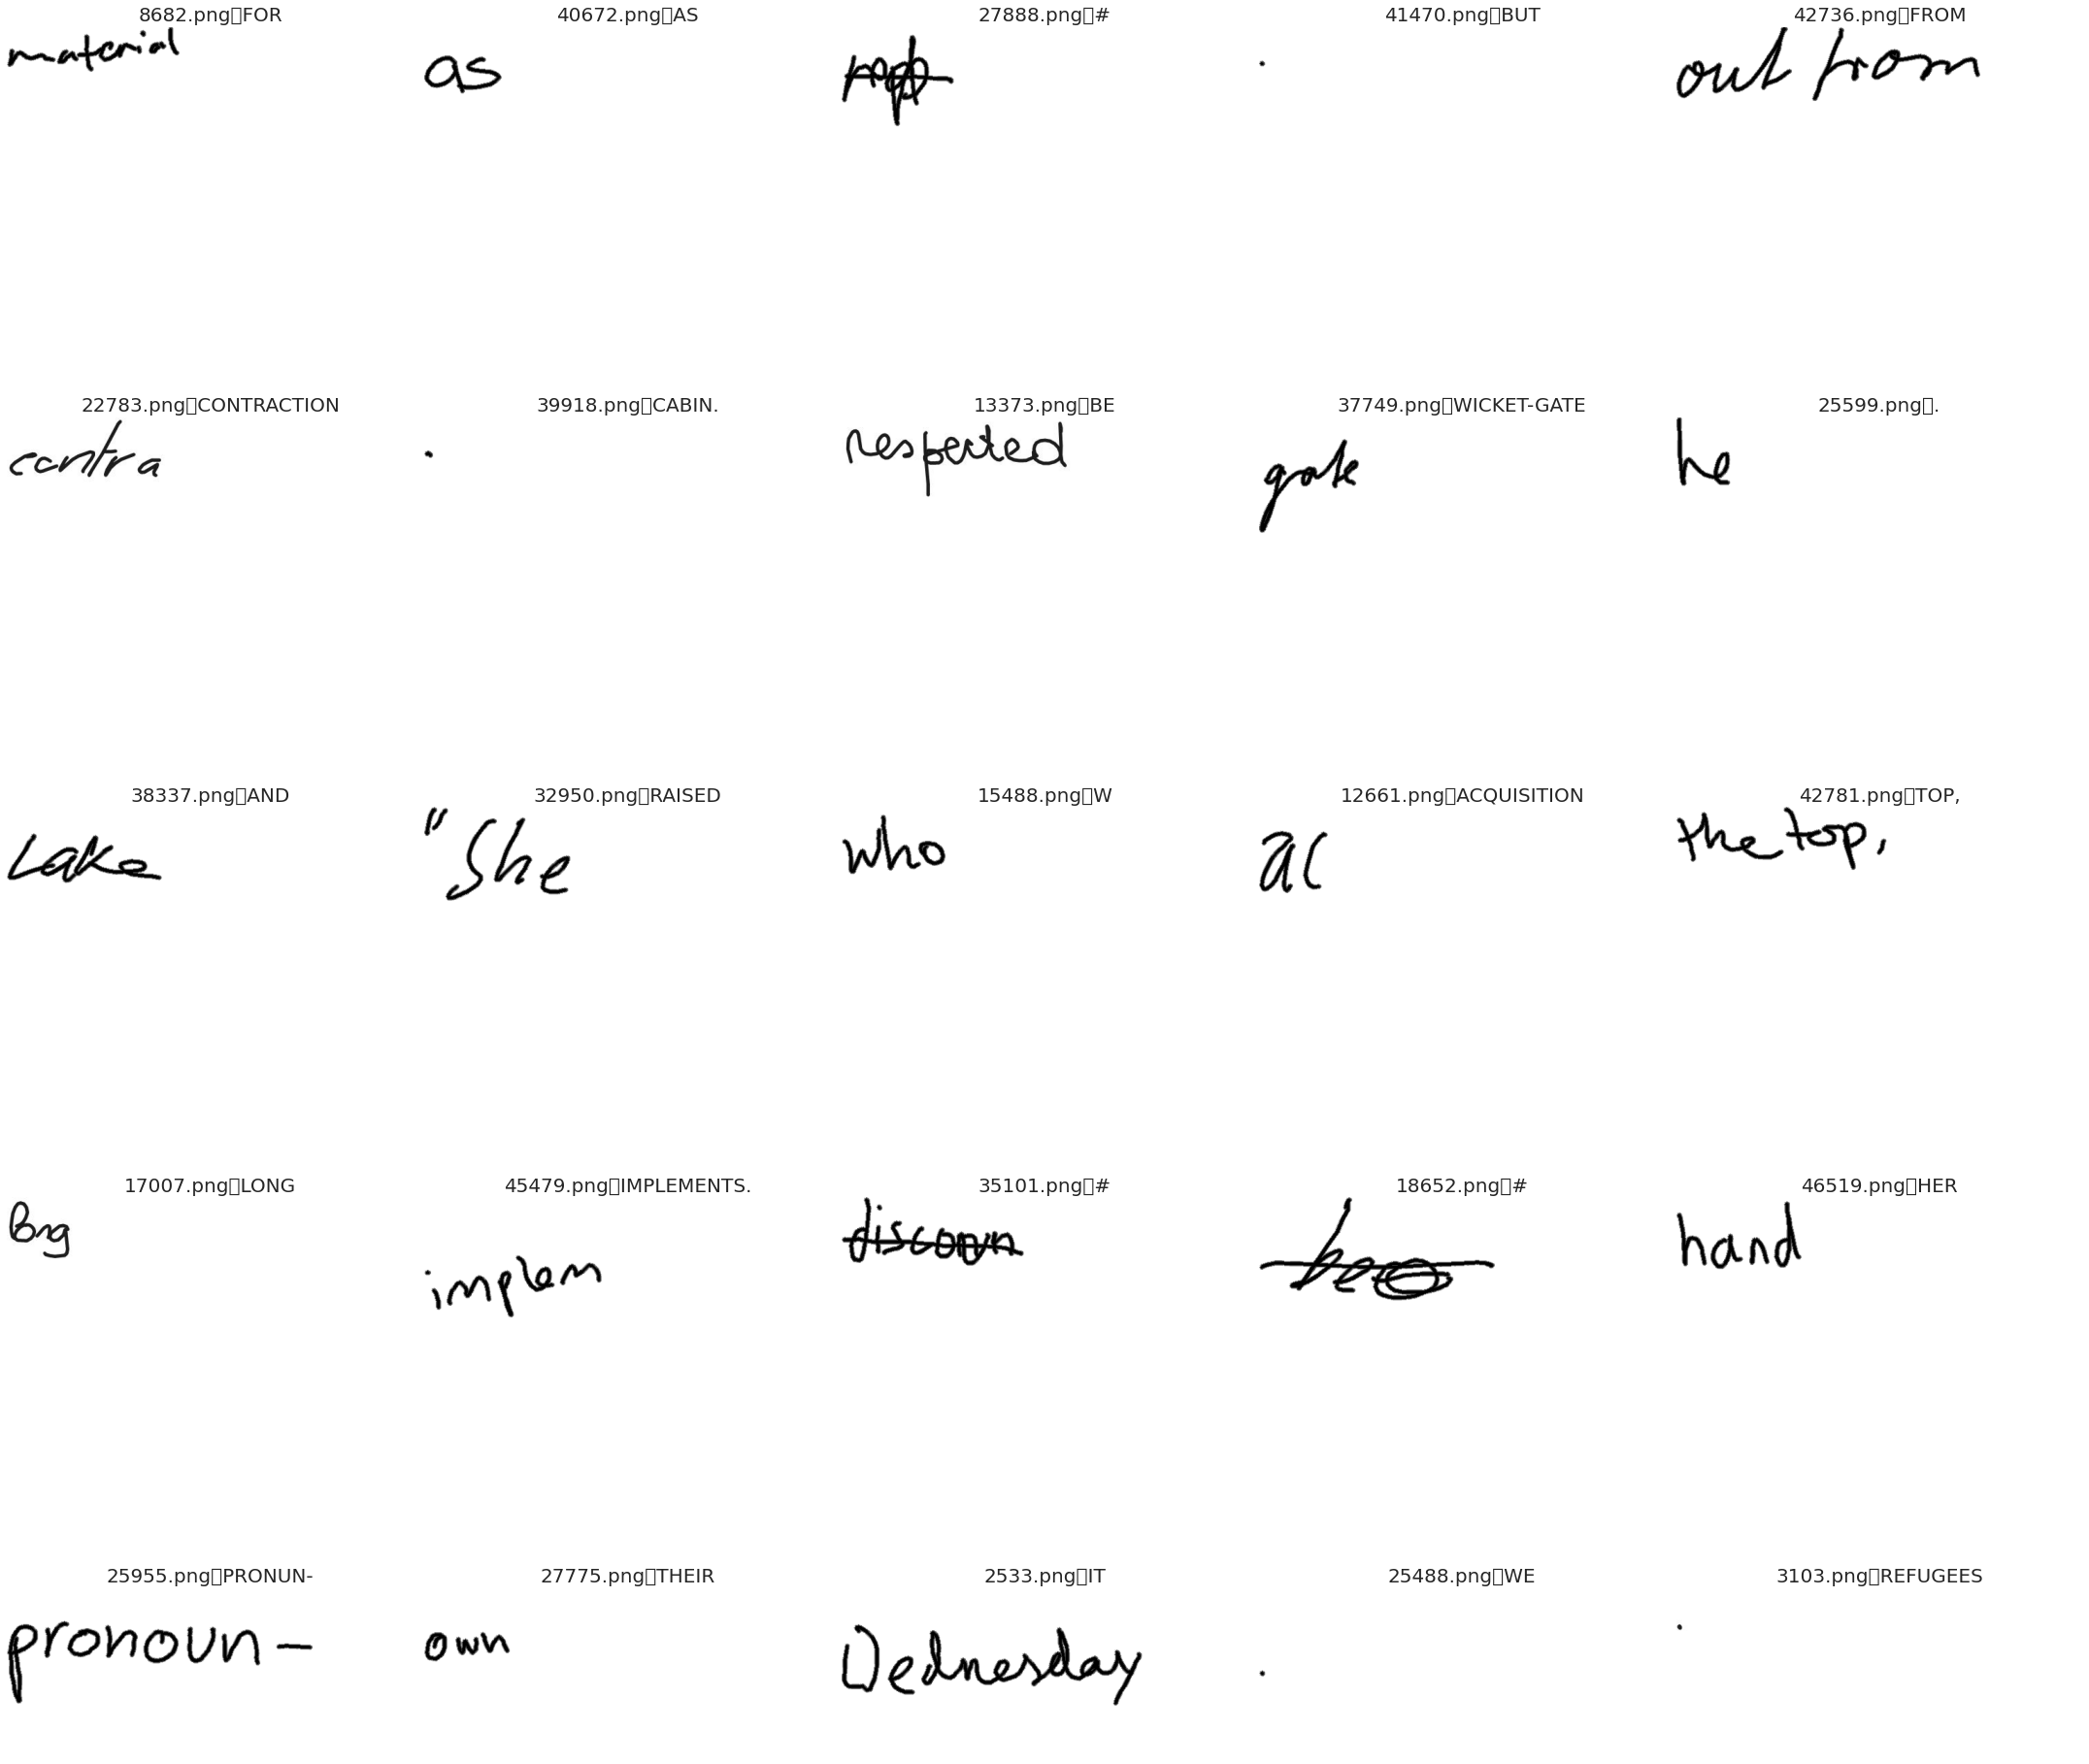

In [59]:
h, w = 5, 5
f, ax = plt.subplots(h, w, figsize=(30, 30))
sub_df = df.loc[df["Path"].isin([f"images/{x}.png" for x in drop_images])].sample(n=h*w)
images = sub_df["Path"].tolist()
labels = sub_df["Labels"].tolist()
for i in range(h*w):
    img = cv2.imread(images[i])
    ax[i // h, i % w].imshow(img, cmap="gray")
    ax[i // h, i % w].axis("off")
    ax[i // h, i % w].set_title(f"{images[i].split('/')[-1]}\t{labels[i]}", fontdict={"fontsize": 20})
plt.tight_layout()
plt.show()

In [60]:
x = drop_images[5]
y = train_df.loc[train_df["Splits"].apply(lambda y: x in y)]["Splits"].tolist()[0]
print(x, y)

27370 [27367, 27368, 27369, 27370, 27371, 27372]


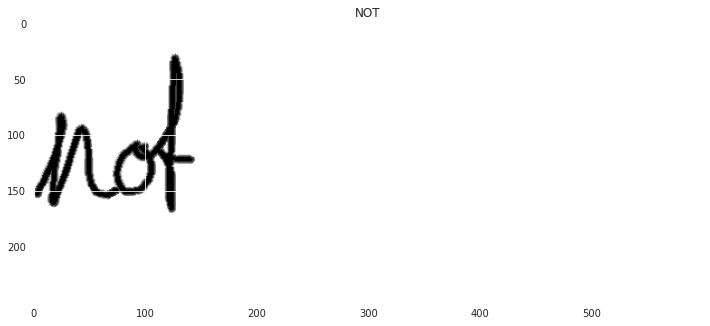

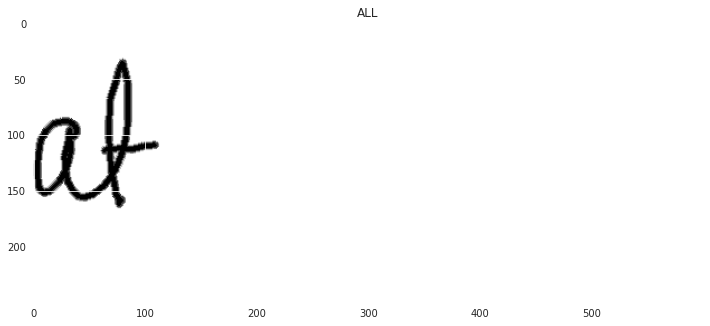

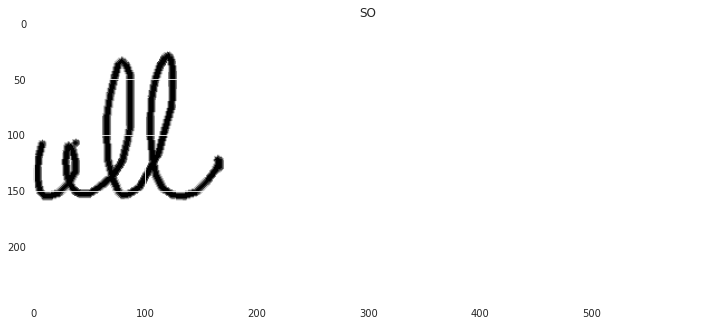

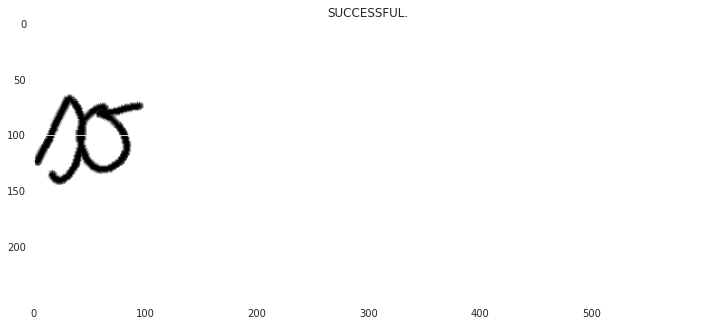

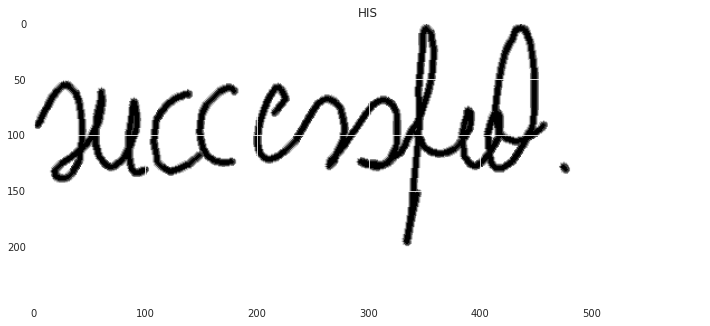

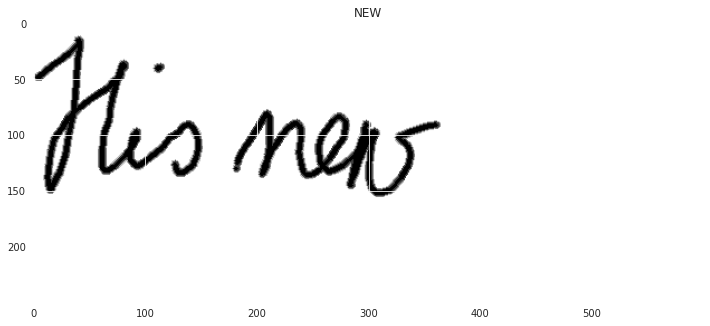

In [61]:
sub_df = df.loc[df["Path"].isin([f"images/{x}.png" for x in y])]
for idx, row in sub_df.iterrows():
    img = cv2.imread(row["Path"])
    label = row["Labels"]
    plt.figure()
    plt.imshow(img)
    plt.title(label)

In [62]:
df_error_paths, train_df_error_indexes = [], []
for x in tqdm(drop_images):
    # storing index for both dataframes
    temp = train_df.loc[train_df["Splits"].apply(lambda y: x in y)]
    train_df_error_indexes.append(temp.index.tolist()[0])
    df_error_paths.extend(temp["Splits"].tolist()[0])
df_error_paths = [f"images/{x}.png" for x in df_error_paths]
print(f"# Total Error Cases: {len(df_error_paths)}")

100%|██████████| 352/352 [00:01<00:00, 252.83it/s]

# Total Error Cases: 2391


In [63]:
print(f"# Word Level Errors: {len(df_error_paths)}")
print(f"# Word Level Errors (Unique): {len(set(df_error_paths))}")
print(f"# Sentence Level Errors: {len(train_df_error_indexes)}")
print(f"# Sentence Level Errors (Unqiue): {len(set(train_df_error_indexes))}")
print(f"Sanity Check: {train_df.loc[train_df_error_indexes]['NumSplits'].sum()==len(df_error_paths)}")

# Word Level Errors: 2391
# Word Level Errors (Unique): 2037
# Sentence Level Errors: 352
# Sentence Level Errors (Unqiue): 303
Sanity Check: True


**NOTE:** Can no longer rely on index to discard images from `df`

In [64]:
# storing from both dataframes
df = df[~df["Path"].isin(df_error_paths)]
train_df = train_df.drop(index=train_df_error_indexes)

In [65]:
df.shape, train_df.shape

((42761, 2), (8044, 3))

In [66]:
print(f"Sanity Check Again: {train_df['NumSplits'].sum()==df.shape[0]}")

Sanity Check Again: True


In [67]:
df.head()

,Path,Labels
7,images/7.png,FROM
8,images/8.png,NOMNATING
9,images/9.png,ANY
10,images/10.png,MORE
11,images/11.png,LABOUR


In [68]:
train_df.head()

,Path,Splits,NumSplits
1,../input/arya-hw-lines/train/train/a01-000u-02...,"[7, 8, 9, 10, 11]",5
2,../input/arya-hw-lines/train/train/a01-000u-03...,"[12, 13, 14, 15, 16, 17, 18, 19]",8
3,../input/arya-hw-lines/train/train/a01-000u-04...,"[20, 21, 22, 23, 24, 25]",6
4,../input/arya-hw-lines/train/train/a01-000u-05...,"[26, 27, 28, 29, 30, 31, 32, 33]",8
5,../input/arya-hw-lines/train/train/a01-000u-06...,"[34, 35, 36, 37]",4


## Random Plots

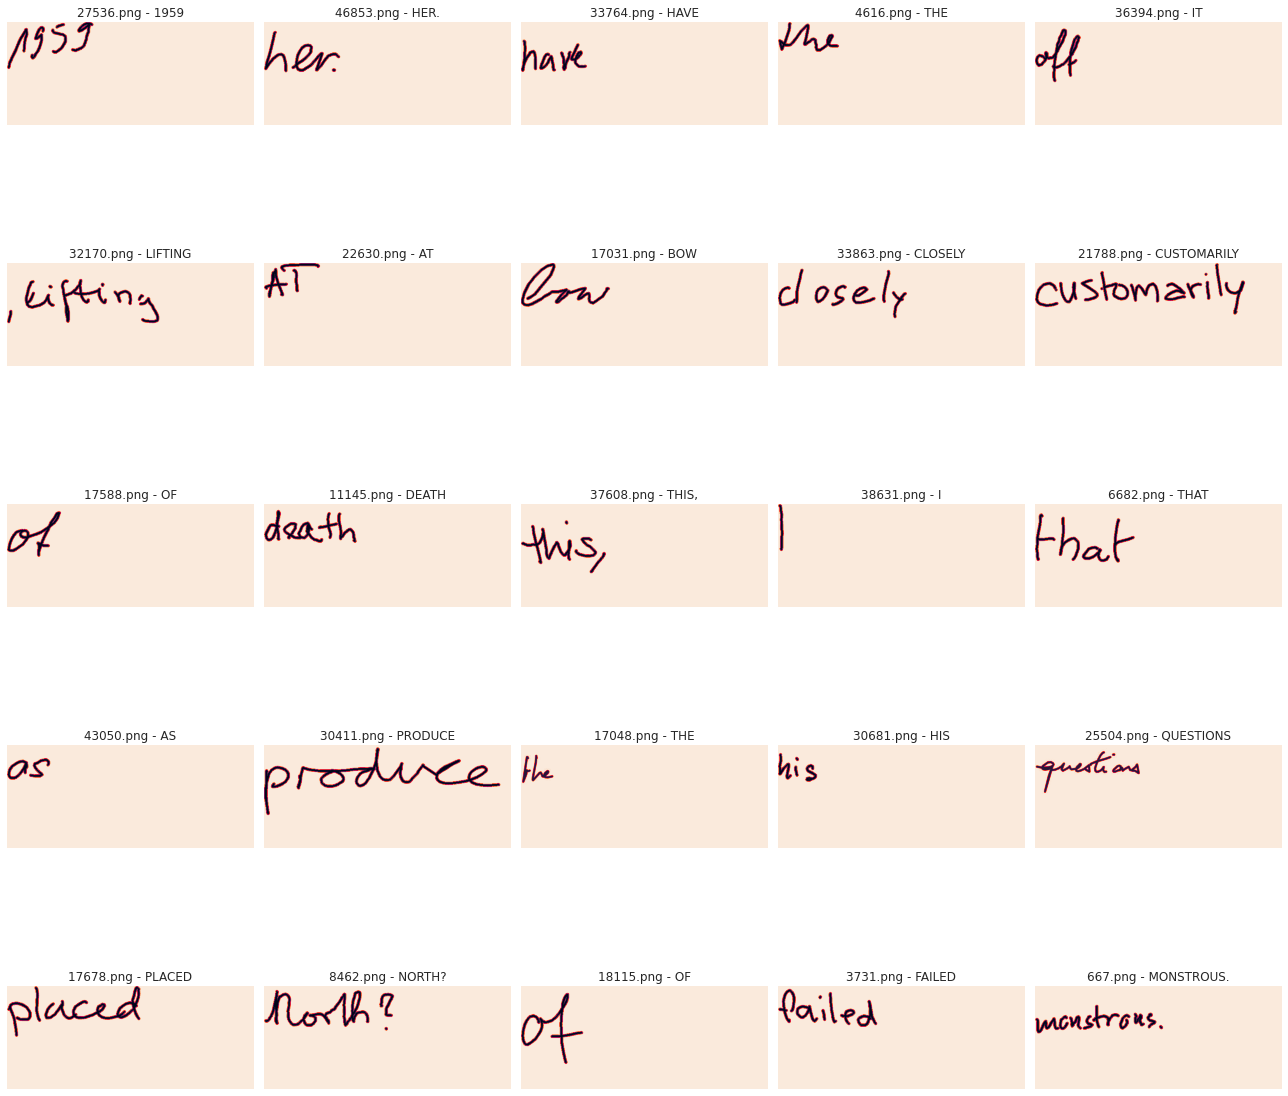

In [69]:
plot_grid(df["Path"].tolist(), df["Labels"].tolist(), h=5, w=5)

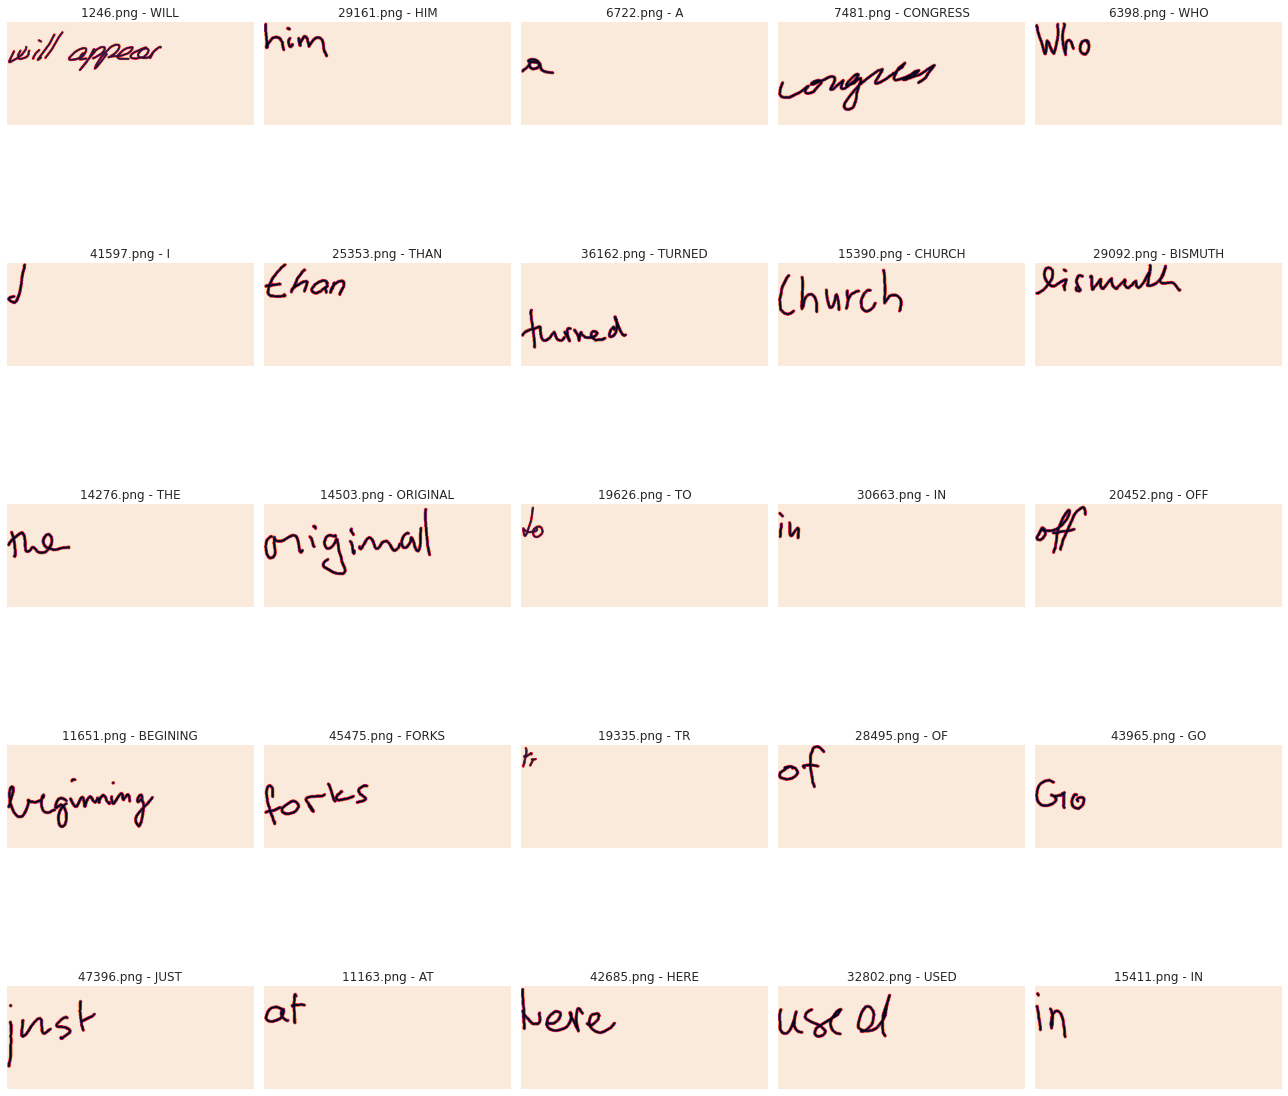

In [70]:
plot_grid(df["Path"].tolist(), df["Labels"].tolist(), h=5, w=5)

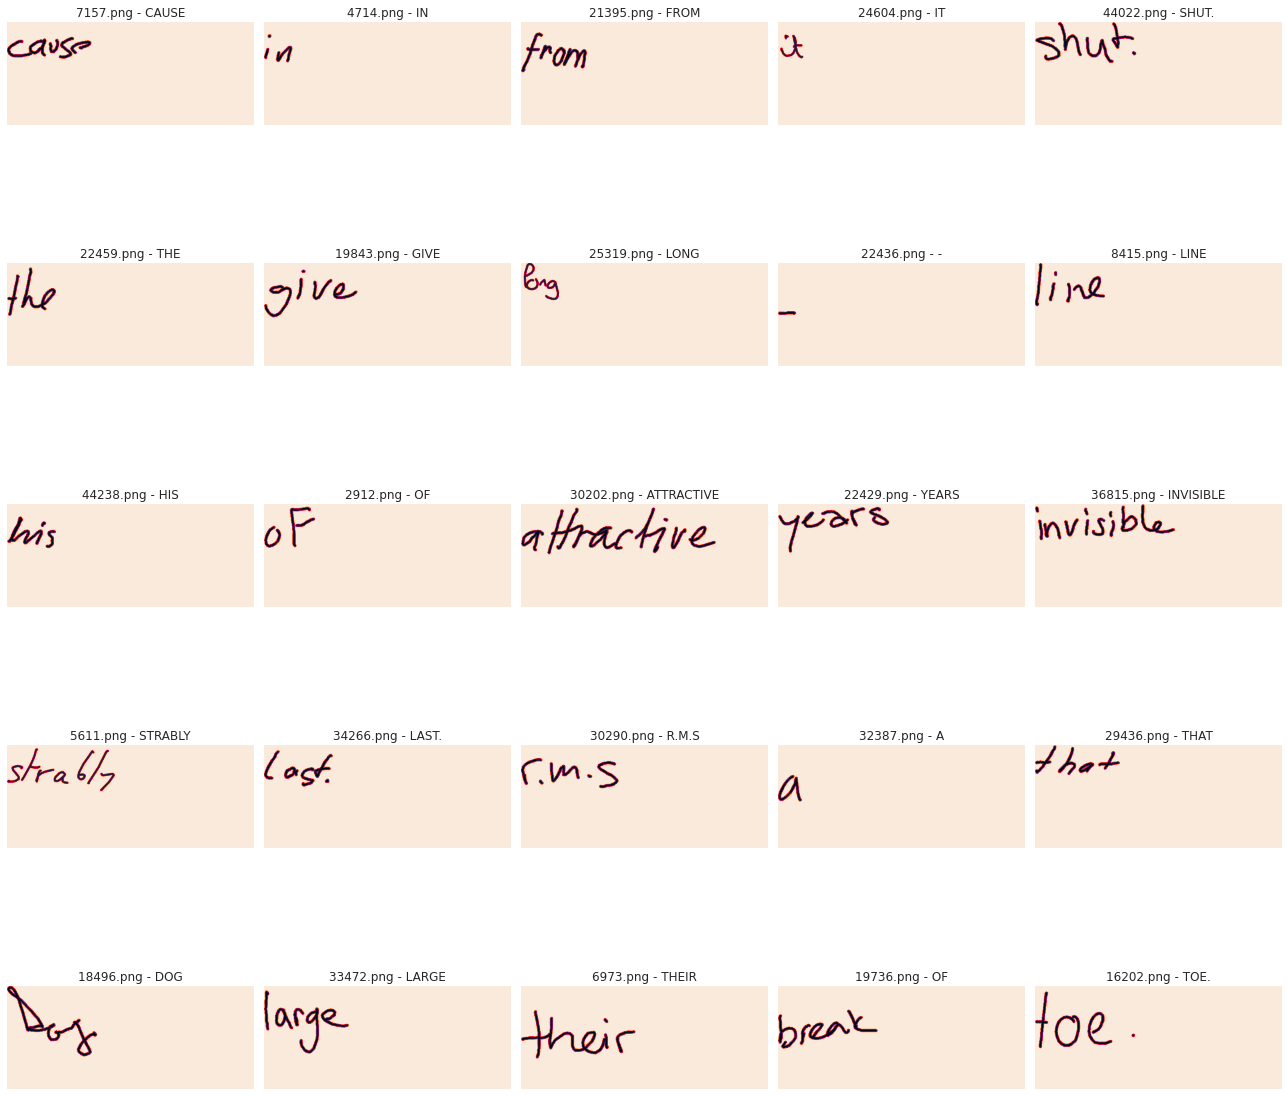

In [71]:
plot_grid(df["Path"].tolist(), df["Labels"].tolist(), h=5, w=5)

Modifying metadata to store labels

In [72]:
labels = []
for idx, row in train_df.iterrows():
    path = row["Path"]
    with open(path.replace(".tif", ".gt.txt")) as file:
        label = file.read()
    labels.append(label)

In [73]:
train_df["Labels"] = labels
train_df["Path"] = train_df["Path"].str.replace("../input/arya-hw-lines/train/train/", "")

In [74]:
train_df.sample(n=5)

,Path,Splits,NumSplits,Labels
2808,d09-618z-04.tif,"[15101, 15102, 15103, 15104, 15105]",5,"GESTURE, SO WE HAVE GOT"
848,b01-024z-05.tif,"[4586, 4587, 4588, 4589, 4590, 4591, 4592, 4593]",8,QUEEN HAS WON A TRIUMPH. IT WOULD BE
3934,f06-391z-07.tif,"[21329, 21330, 21331, 21332, 21333, 21334, 21335]",7,"LITE THE PARADE, BECAME AN ACCEPTET PART"
7766,n03-248z-03.tif,[],0,"LAUGH. ""I DID,"" HE SAID; ""BUT I 'D"
6802,l06-695z-07.tif,"[36784, 36785, 36786, 36787, 36788]",5,"HANDS, AND THE POUTER BOSOM"


In [75]:
df.to_csv("train.csv")
train_df.to_csv("metadata.csv")

In [76]:
!zip --quiet -r images.zip images
!rm -rf images/
!rm *.png